In [1]:
import jax.numpy as jnp
from jax import random
import jax.scipy as jsp
import jax

from jaxgp.utils import CovMatrixDD, CovMatrixFD, CovMatrixFF
from jaxgp.kernels import RBF
from jaxgp import covar

import matplotlib.pyplot as plt

In [2]:
def fun(x, noise=0.0, key = random.PRNGKey(0)):
    return (x[:,0]**2 + x[:,1] - 11)**2 / 800.0 + (x[:,0] + x[:,1]**2 -7)**2 / 800.0 + random.normal(key,(len(x),), dtype=jnp.float32)*noise

def grad(x, noise=0.0, key = random.PRNGKey(0)):
    dx1 = 4 * (x[:,0]**2 + x[:,1] - 11) * x[:,0] + 2 * (x[:,0] + x[:,1]**2 -7)
    dx2 = 2 * (x[:,0]**2 + x[:,1] - 11) + 4 * (x[:,0] + x[:,1]**2 -7) * x[:,1]
    return jnp.vstack((dx1, dx2)).T / 800.0 + random.normal(key,x.shape, dtype=jnp.float32)*noise

In [3]:
# Interval bounds from which to choose the data points
bounds = jnp.array([-5.0, 5.0])

# How many function and derivative observations should be chosen
num_f_vals = 10
num_d_vals = 100
num_ref_points = (num_d_vals + num_f_vals) // 5

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, (num_f_vals, 2), minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, (num_d_vals,2), minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.1
key, subkey = random.split(key)
y_func = fun(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = grad(x_der, noise, subkey)


kernel = RBF()
# an RBF kernel has per default 2 parameters
init_kernel_params = jnp.array([1.0, 1.0])

In [4]:
def sparse_covariance_matrix(X_split, Y_train, X_ref, noise, kernel, params):
    KF = CovMatrixFF(X_ref, X_split[0], kernel, params)
    KD = CovMatrixFD(X_ref, X_split[1], kernel, params)
    
    K_MN = jnp.hstack((KF,KD))

    K_ref = CovMatrixFF(X_ref, X_ref, kernel, params)
        
    sparse_covmatrix = noise**2 * K_ref + K_MN@K_MN.T
    projected_labels = K_MN@Y_train
    return sparse_covmatrix, projected_labels

def full_covariance_matrix(X_split, noise, kernel, params):
    KF = CovMatrixFF(X_split[0], X_split[0], kernel, params)
    KD = CovMatrixFD(X_split[0], X_split[1], kernel, params)
    KDD = CovMatrixDD(X_split[1], X_split[1], kernel, params)

    K_NN = jnp.vstack((jnp.hstack((KF,KD)), 
                       jnp.hstack((KD.T,KDD))))

    return K_NN + jnp.eye(len(K_NN)) * (noise**2)

In [5]:
X_train = (x_func, x_der)
Y_train = jnp.hstack((y_func, y_der.reshape(-1)))
X_ref_rand = random.permutation(subkey, jnp.vstack((x_der,x_func)))[:num_ref_points]
X_ref_even = jnp.array(jnp.meshgrid(jnp.linspace(*bounds, round(jnp.sqrt(num_ref_points))),jnp.linspace(*bounds, round(jnp.sqrt(num_ref_points))))).reshape(2,-1).T

In [6]:
# KF = CovMatrixFF(X_ref_even, X_train[0], kernel, init_kernel_params)
# KD = CovMatrixFD(X_ref_even, X_train[1], kernel, init_kernel_params)

# K_MN = jnp.hstack((KF,KD))

# K_ref = CovMatrixFF(X_ref_even, X_ref_even, kernel, init_kernel_params)

KF = CovMatrixFF(X_ref_rand, X_train[0], kernel, init_kernel_params)
KD = CovMatrixFD(X_ref_rand, X_train[1], kernel, init_kernel_params)

K_MN = jnp.hstack((KF,KD))

K_ref = CovMatrixFF(X_ref_rand, X_ref_rand, kernel, init_kernel_params)

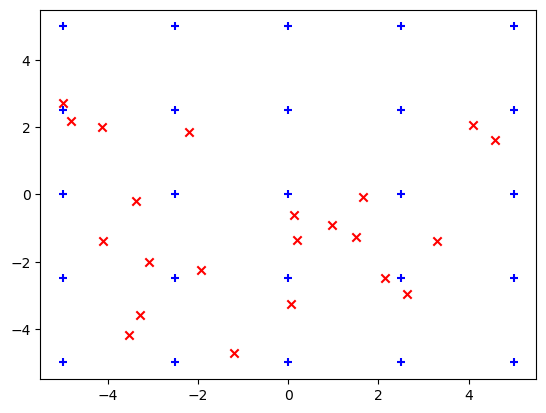

In [7]:
plt.scatter(X_ref_rand[:,0], X_ref_rand[:,1], marker="x", color="r")
plt.scatter(X_ref_even[:,0], X_ref_even[:,1], marker="+", color="b")

In [8]:
print(jsp.linalg.det(K_ref))
print(jnp.linalg.cond(K_ref))
print(jnp.linalg.slogdet(K_ref)[1])

2.1000533e-05
59.95332
-10.770963


In [9]:
K_PI = jsp.linalg.solve(K_ref.T@K_ref, K_ref.T)

In [10]:
print(jsp.linalg.det(K_ref.T@K_ref))
print(jnp.linalg.cond(K_ref.T@K_ref))
print(jnp.linalg.slogdet(K_ref.T@K_ref)[1])

4.4102494e-10
3594.629
-21.54192


In [11]:
K = K_MN.T@jsp.linalg.cho_solve(jsp.linalg.cho_factor(K_ref), K_MN) + jnp.eye(len(Y_train))*(noise**2)

In [12]:
print(jsp.linalg.det(K))
print(jnp.linalg.cond(K))
print(jnp.linalg.slogdet(K)[1])

K_INV = jsp.linalg.inv(K)

print(jsp.linalg.det(K_INV))
print(jnp.linalg.cond(K_INV))
print(jnp.linalg.slogdet(K_INV)[1])

0.0
730.13257
-842.6814
inf
730.08435
842.68134


In [13]:
_, logdet = jnp.linalg.slogdet(K)
# nlle = 0.5*(logdet + 
#             Y_train@jsp.linalg.solve(K, Y_train) + 
#             len(Y_train)*jnp.log(2*jnp.pi))
nlle = 0.5*(logdet + 
            Y_train@jsp.linalg.cho_solve(jsp.linalg.cho_factor(K), Y_train) + 
            len(Y_train)*jnp.log(2*jnp.pi))

In [14]:
print(nlle)

12.818176


In [15]:
Y_train = Y_train*1.01

In [16]:
K = K_MN.T@jsp.linalg.solve(K_ref,K_MN) + jnp.eye(len(Y_train))*(noise**2)
_, logdet = jnp.linalg.slogdet(K)
# nlle = 0.5*(logdet + 
#             Y_train@jsp.linalg.solve(K, Y_train) + 
#             len(Y_train)*jnp.log(2*jnp.pi))
nlle = 0.5*(logdet + 
            Y_train@jsp.linalg.cho_solve(jsp.linalg.cho_factor(K), Y_train) + 
            len(Y_train)*jnp.log(2*jnp.pi))

In [17]:
print(nlle)

17.665268


In [18]:
K_NN = full_covariance_matrix(X_train, noise, kernel, init_kernel_params)

In [19]:
print(jsp.linalg.det(K_NN))
print(jnp.linalg.cond(K_NN))
print(jnp.linalg.slogdet(K_NN)[1])

0.0
839.623
-409.57666


In [20]:
import gpytorch
import torch
import numpy as onp

In [21]:
ker = gpytorch.kernels.RBFKernelGrad()
ker.lengthscale = 1.0

In [22]:
np = 9
key, subkey = random.split(random.PRNGKey(seed))
x_jax = random.uniform(subkey, (np**2, 2), minval=bounds[0], maxval=bounds[1])
x_jax = jnp.array(jnp.meshgrid(jnp.linspace(*bounds, np), jnp.linspace(*bounds, np))).reshape(2,-1).T
# y_jax = fun(x_jax, noise)
# dy_jax = grad(x_jax, noise)

x_torch = torch.Tensor(onp.array(x_jax))

In [23]:
cov_torch = ker(x_torch).to_dense()
cov_torch += torch.eye(len(cov_torch)) * noise**2
cov_torch = cov_torch.detach().numpy()

In [24]:
cov_jax = jax.jit(full_covariance_matrix)((x_jax, x_jax), noise, kernel, init_kernel_params)

In [48]:
onp.linalg.det(4*cov_jax) / 4**len(cov_jax)

2.2082114193333883e-17

In [49]:
onp.linalg.det(4*cov_torch) / 4**len(cov_torch)

2.2081832951925615e-17

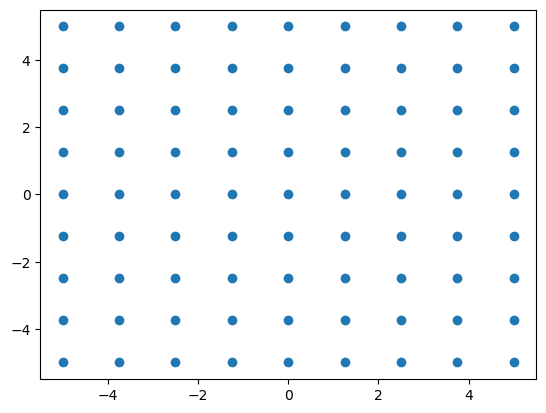

In [27]:
plt.scatter(x_jax[:,0], x_jax[:,1])

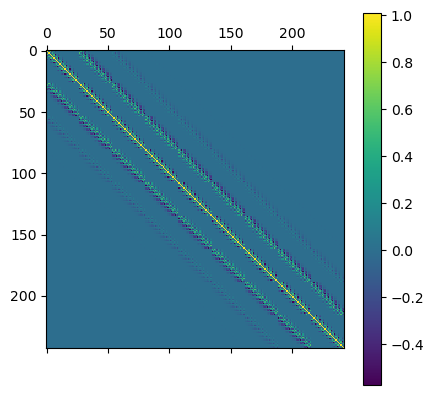

In [28]:
plt.matshow(cov_torch)
plt.colorbar()

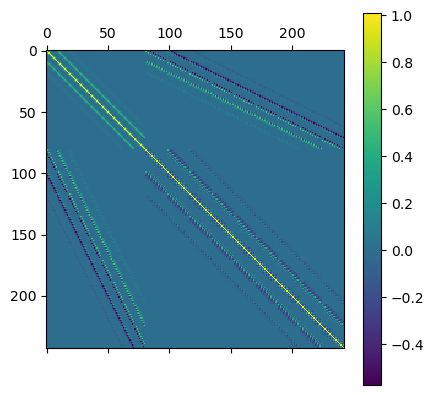

In [29]:
plt.matshow(cov_jax)
plt.colorbar()

In [30]:
ker_nograd = gpytorch.kernels.RBFKernel()
ker_nograd.lengthscale = 1.0

In [31]:
cov_torch = ker_nograd(x_torch).to_dense()
cov_torch += torch.eye(len(cov_torch)) * noise**2
cov_torch = cov_torch.detach().numpy()

In [32]:
cov_jax = jax.jit(covar.full_covariance_matrix_nograd)(x_jax, noise, kernel, init_kernel_params)

In [51]:
onp.linalg.det(4*cov_jax) / 4**len(cov_jax)

2.2082114193333883e-17

In [52]:
onp.linalg.det(4*cov_torch) / 4**len(cov_torch)

2.2081832951925615e-17

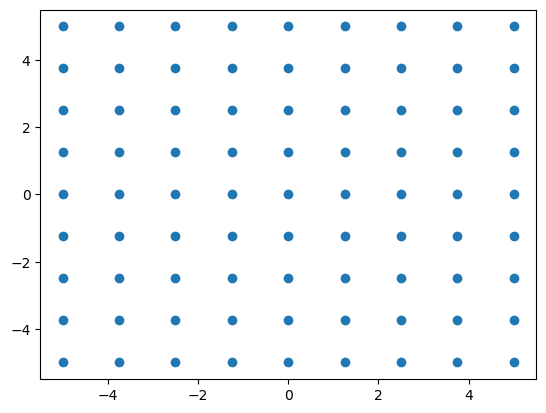

In [35]:
plt.scatter(x_jax[:,0], x_jax[:,1])

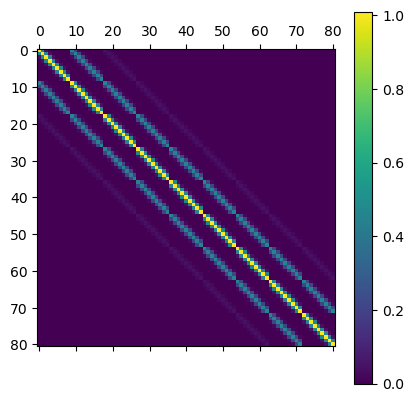

In [36]:
plt.matshow(cov_torch)
plt.colorbar()

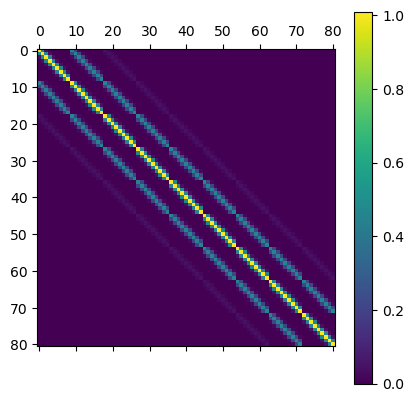

In [37]:
plt.matshow(cov_jax)
plt.colorbar()